# Read tiles to input format VAE network

### Imports
Install tensorflow:
``%pip install tensorflow``

In [1]:
#%pip install tensorflow

In [2]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

### Create sampling layer

In [3]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


### Build encoder


In [4]:
latent_dim = 2
encoder_inputs = keras.Input(shape=(20, 20,3)) # enter cut-out shape (20,20,3)
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x) # to vector
x = layers.Dense(16, activation="relu")(x) # linked layer
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 20, 20, 3)]  0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 10, 10, 32)   896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 5, 5, 64)     18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 1600)         0           conv2d_1[0][0]                   
____________________________________________________________________________________________

### Build decoder

In [5]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(5 * 5 * 64, activation="relu")(latent_inputs) # -- shape corresponding to encoder
x = layers.Reshape((5, 5, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(3, 3, activation="sigmoid", padding="same")(x)


decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1600)              4800      
_________________________________________________________________
reshape (Reshape)            (None, 5, 5, 64)          0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 10, 10, 64)        36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 20, 20, 32)        18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 20, 20, 3)         867       
Total params: 61,059
Trainable params: 61,059
Non-trainable params: 0
_______________________________________________________

## Define VAE as model
With custom train_step

In [6]:

class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }


## Load Data

### mnist dataset

In [7]:
# (x_train, _), (x_test, _) = keras.datasets.mnist.load_data() # reads data as numpy.ndarray

# mnist_digits = np.concatenate([x_train, x_test], axis=0) # [70000,28,28]
# print(type(mnist_digits), np.shape(mnist_digits))

# mnist_digits = np.expand_dims(mnist_digits, -1).astype("float32") / 255  # adds 4th dimension (bands) [70000,28,28,1]
# print(type(mnist_digits),np.shape(mnist_digits))



### Stored cut-outs
The VAE reads the example mnist data as ndarray. Therefore: read our cut-outs to np.ndarray

#### List cut-out files on disk

In [8]:
import os

imPath = '/Users/maaikeizeboud/Documents/Data/tiles_test/'
imgs = sorted([file for file in os.listdir(imPath) if file.endswith('.tif') ]) # list with image names
len(imgs)

1000

#### Import using rasterio
Importing the .tif images using the keras ``load_img`` functions doesnt work well because it uses Pillow, which has trouble with .tif/.tiff.

The .tif files are read to numpy.ndarray in the NCHW format (bands,rows,cols). Conv2DCustomBackpropInputOp only supports NHWC (Batch Size, Height of the Image, Width of the Image and Number of Channels), so reshape data.

In [9]:
import rasterio
from rasterio.plot import reshape_as_raster, reshape_as_image

# get tile size information to initialise ndarray 
with rasterio.open(imPath + imgs[0]) as src:
    imShape = [src.width, src.height,src.count]  # returns ( rows , cols, bands)
# initialise ndarray    
images = np.expand_dims( np.empty(imShape) , 0).astype("float32"); # expand to 4th dimension to stack all images

# load cut-outs
for i in imgs:
    with rasterio.open(imPath + i) as src:
        imArray = src.read([1,2,3]) # reads all bands , returns np.ndarray (bands,rows,cols)
        imArray = reshape_as_image(imArray) # reshapes to (rows,cols,bands)
        imArray = np.expand_dims(imArray, 0).astype("float32")  # ( 1, bands , rows , cols)
        images = np.concatenate((images, imArray),axis=0) # stack data ( N_imgs, bands, rows, cols)
        
print(images.shape)
print(np.min(images),np.max(images))

(1001, 20, 20, 3)
0.0 15472.0


In [10]:
# -- normalise images to <0,1> open interval
imax = np.max(images) # 15.000-ish
images_norm = (images.astype('float32')+0.1)/ (imax+1) 

# -- check values in data
print(np.min(images_norm),np.max(images_norm))
print('0-values in data: ',np.any(images_norm == 0))
print('1-values in data: ',np.any(images_norm == 1))
print('nan-values in data: ',np.any(np.isnan(images_norm)))
print('inf-values in data: ',np.any(np.isinf(images_norm)))


6.4628707e-06 0.9999418
0-values in data:  False
1-values in data:  False
nan-values in data:  False
inf-values in data:  False


## Train model

In [19]:
# data = mnist_digits #[70000,28,28,1]
# data = images; #[1001,3,20,20]
data = images_norm;

vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())

vae.fit(data, epochs=10, batch_size=128)

Epoch 1/10
8/8 [==============================] - 1s 41ms/step - loss: 258.0381 - reconstruction_loss: 257.1331 - kl_loss: 0.6629
Epoch 2/10
8/8 [==============================] - 0s 41ms/step - loss: 258.2425 - reconstruction_loss: 257.0539 - kl_loss: 0.6921
Epoch 3/10
8/8 [==============================] - 0s 40ms/step - loss: 258.1159 - reconstruction_loss: 256.9289 - kl_loss: 0.7111
Epoch 4/10
8/8 [==============================] - 0s 39ms/step - loss: 257.8341 - reconstruction_loss: 256.9243 - kl_loss: 0.6994
Epoch 5/10
8/8 [==============================] - 0s 40ms/step - loss: 258.1285 - reconstruction_loss: 256.8369 - kl_loss: 0.6182
Epoch 6/10
8/8 [==============================] - 0s 40ms/step - loss: 258.4021 - reconstruction_loss: 257.0251 - kl_loss: 0.6054
Epoch 7/10
8/8 [==============================] - 0s 42ms/step - loss: 258.5845 - reconstruction_loss: 256.5812 - kl_loss: 0.6674
Epoch 8/10
8/8 [==============================] - 0s 38ms/step - loss: 256.7959 - reconstr

## Display grid of sampled images
For the current training-test, the sampled images are very uniform grey data - which makes sense as the network does not distinguish any features yet with this little of training.

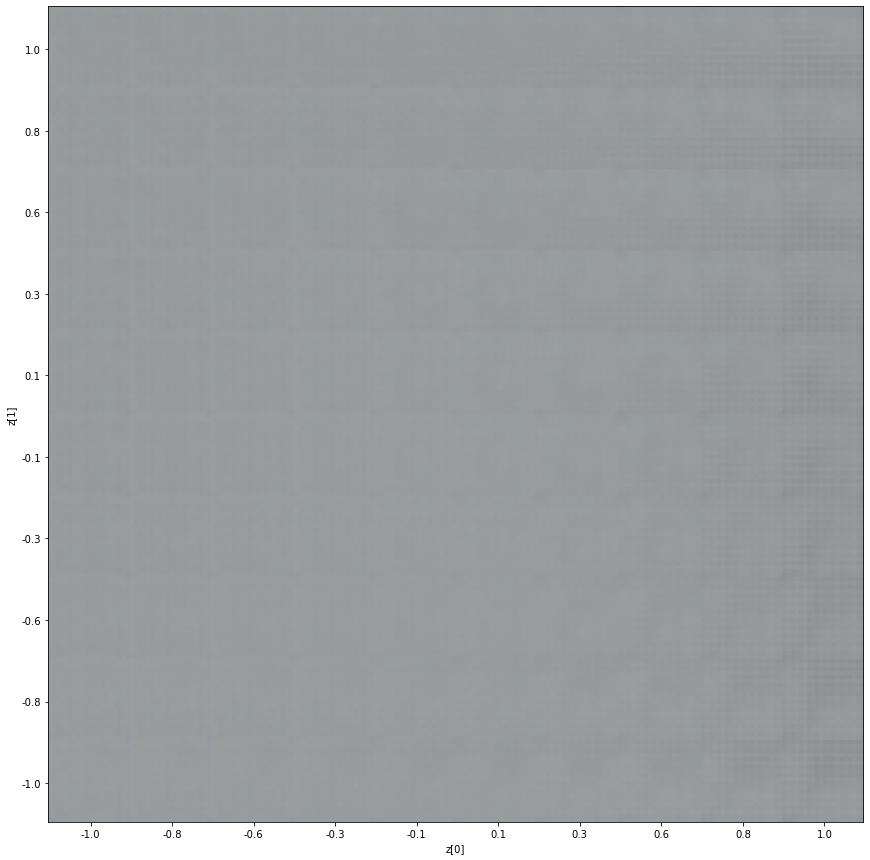

In [20]:
import matplotlib.pyplot as plt


def plot_latent_space(vae, n=10, figsize=15):
    # display a n*n 2D manifold of digits
    digit_size = 20
    scale = 1.0
    figure = np.zeros((digit_size * n, digit_size * n,3)) #add 3rd dim
    # linearly spaced coordinates corresponding to the 2D plot
    # of digit classes in the latent space
    grid_x = np.linspace(-scale, scale, n)
    grid_y = np.linspace(-scale, scale, n)[::-1]

    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = np.array([[xi, yi]])
            x_decoded = vae.decoder.predict(z_sample)
#             print(x_decoded[0].shape) #[20,20,3]
            digit = x_decoded[0]#.reshape(digit_size, digit_size) # do not reshape: keep all 3 bands
            figure[
                i * digit_size : (i + 1) * digit_size,
                j * digit_size : (j + 1) * digit_size,
                : # add all 3 bands
            ] = digit

    plt.figure(figsize=(figsize, figsize))
    start_range = digit_size // 2
    end_range = n * digit_size + start_range
    pixel_range = np.arange(start_range, end_range, digit_size)
    sample_range_x = np.round(grid_x, 1)
    sample_range_y = np.round(grid_y, 1)
    plt.xticks(pixel_range, sample_range_x)
    plt.yticks(pixel_range, sample_range_y)
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.imshow(figure, cmap='viridis')#"Greys_r")
    plt.show()


plot_latent_space(vae)

### Show original cut-outs.

In [18]:

# def plot_images(images, n, figsize=15):
#     # display a n*n 2D manifold of images
    
#     fig, axes = plt.subplots(n, n,figsize=(figsize,figsize))
#     fig.suptitle('Display set of '+ str(n**2) +' cut-outs')

#     k=0;
#     for i in range(n):
#         for j in range(n):
#             ax = axes[i,j]
#             ax.imshow(images[k,:,:,0],cmap='Greys_r')
#             k+=1

# plot_images(images_norm,5)   

## Display latent space clustering

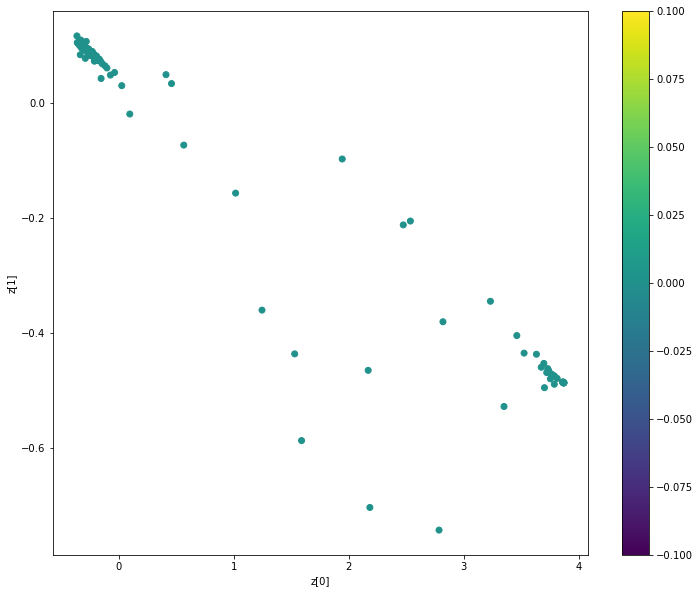

In [17]:

def plot_label_clusters(vae, data,labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
#     plt.scatter(z_mean[:,0],z_mean[:,1])
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


# (x_train, y_train), _ = keras.datasets.mnist.load_data()
# x_train = np.expand_dims(x_train, -1).astype("float32") / 255
x_train = data;
y_train = np.zeros(len(data))

plot_label_clusters(vae, x_train, y_train)